<a href="https://colab.research.google.com/github/lizalanchu/Cars_Moldova_homework1-/blob/main/%D0%94%D0%B72_Car_Moldova.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import библиотек

In [7]:
import pandas as pd
from google.colab import files 

import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns; 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

#Данные без обработки

## Загрузка данных на Google Drive

In [8]:
uploaded = files.upload()

Saving cars_moldova_no_dup.csv to cars_moldova_no_dup.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [9]:
df = pd.read_csv('/content/cars_moldova_no_dup.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Volkswagen,Golf,1998,Hatchback,1.0,1400.0,Petrol,Manual,2200.0
3,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
4,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
...,...,...,...,...,...,...,...,...,...
37259,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
37260,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
37261,Renault,Modus,2009,Hatchback,225.0,1500.0,Diesel,Manual,4500.0
37262,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


In [10]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

## Линейная регрессия 

Разобъем данные на тренироваочные и тестовые

In [11]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values # x = все параметры кроме Price, y = Price

features_names = df_num.drop(columns = ['Price(euro)']).columns # сохраним имена колонок

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) # разбиваем на тренировочную и тестовую выборку

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37264 entries, 0 to 37263
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  37264 non-null  int64  
 1   Distance              37264 non-null  float64
 2   Engine_capacity(cm3)  37264 non-null  float64
 3   Price(euro)           37264 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1.1 MB


,0,1,2
26079,0.867769,0.001870,0.150015
26080,0.752066,0.002993,0.159516
26081,0.884298,0.002600,0.149715
26082,0.867769,0.001091,0.138814
26083,0.909091,0.002841,0.250025


Создадим функцию потерь и функцию рассчета 

In [12]:
def forward(weights, inputs):
    return inputs.dot(weights.T) # возвращает матричное произведение инпутов на весы транспонированные 

def loss_func(predicts, labels):
        return np.square(predicts - labels)  

Протестируем функции

In [13]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[ 0.10035085 -0.699162    0.41793569]
0.19716171321004378 7750.0 7749.80283828679


In [14]:
def grad_loss(predicts, labels, inputs):
    return 2*(predicts - labels)*inputs/inputs.size

Проведем расчет градиента ошибки

In [15]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-1.37343315 -1.051733    0.0548508 ]
[-1.03918700e+07 -1.00766516e+09 -9.30152459e+06]


Определим функцию обновления весов

In [16]:
def update_weights(grad, weights, lerning_rate):
    return weights - lerning_rate*grad

теперь проведем обновление весовых параметров

In [17]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  103917.32628523 10076650.58679642    93015.30074492]


Создадим функцию инициации весов

In [18]:
def weights_init(weights, random_state=42):
    if np.ndim(weights)<1:
        weights = np.zeros(weights)
        
    np.random.seed(random_state)
    return np.random.randn(*weights.shape)/np.sqrt(weights.size)

In [19]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.28677805, -0.07982693,  0.37394315])

Создадим функцию обучения 

In [20]:
def fit(X, y, weights, lr,  epochs=30):
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape); # задаем веса
        loss = 0; # начальное значение функции потерь
        
        for m in range(X.shape[0]): 
            yhat  = forward(weights, X[m,:]) # считаем значение целевой переменной
            grad += grad_loss(yhat,  y[m], X[m,:]) # градиент
            loss += loss_func(yhat,  y[m]) # функцию потерь 

        weights = update_weights(grad/X.shape[0],weights, lr)  # обновляем веса
        cost[i] = loss/X.shape[0] # запоминаем текущую функцию потерь
    
    return weights, cost

Протестируем обучение

In [21]:
def plot_cost(cost):
    plt.plot(cost, 'o-', linewidth = 4, markersize = 15, mfc='none' ); 
    plt.grid()
    plt.xlabel("Эпоха",fontsize=35)
    plt.ylabel("Функция Потерь",fontsize=35)
    plt.xticks(FontSize = 25)

    plt.yticks(FontSize = 25);  

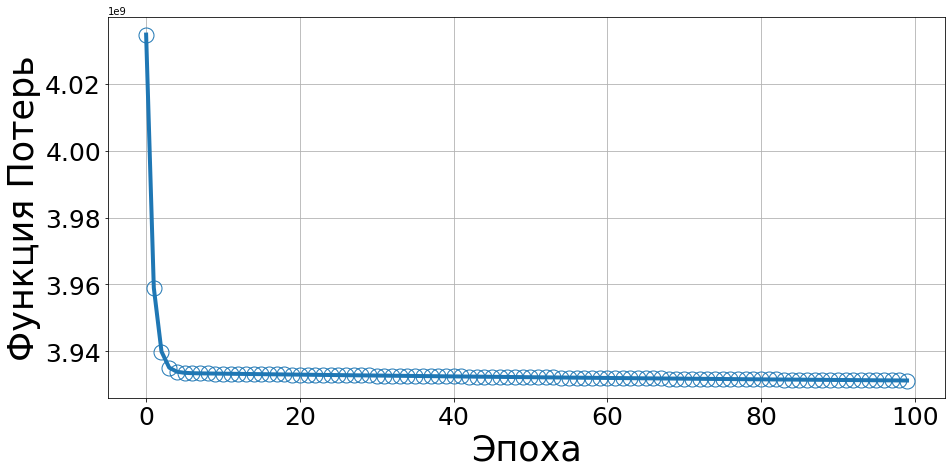

In [22]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost);

Создадим функцию предсказания

In [23]:
def predict(weights, inputs):
    yhat = np.zeros(inputs.shape[0])
    
    for m in range(inputs.shape[0]):
        yhat[m] = inputs[m,:].dot(weights.T)
    
    return yhat

посмотрим как выглядят наши ответы на фоне реальных

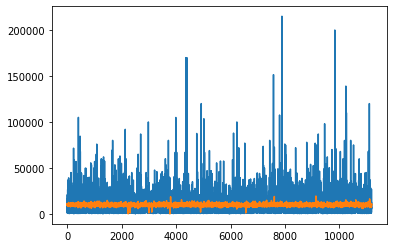

In [24]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted');

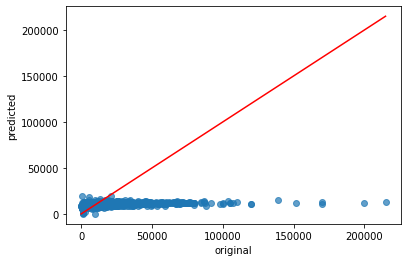

In [25]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted');

Оценим линейную регрессию

MSE

In [26]:
def mean_square_error(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return np.mean(np.sum(np.square(labels-predicts)))

In [27]:
mean_square_error(weights, X_test, y_test)

1096647359727.928

MAE

In [28]:
def mean_absolute_error(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return np.mean(np.sum(np.abs(labels-predicts)))

In [29]:
mean_absolute_error(weights, X_test, y_test)

69415675.24088734

Коэффициент детерминации


In [30]:
def r2_score(weights, inputs, labels):
    predicts = predict(weights, inputs)
    return 1-np.sum(np.square(labels-predicts))/np.sum(np.square(labels-np.mean(labels)))

In [31]:
r2_score(weights, X_test, y_test)

0.09088197587898528

In [32]:
BATCH = 5000

def fit_SGD(X, y, weights, lr,  epochs=30, batch_size = BATCH, random_state = 42):
    
    np.random.seed(random_state)
    
    
    cost = np.zeros(epochs)
    for i in range(epochs): 
        
        grad = np.zeros(weights.shape);
        loss = 0;
        
        idx_batch = np.random.randint(0,X.shape[0],batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        y_batch   = np.take(y, idx_batch)

        
        for m in range(batch_size): 
            yhat  = forward(weights, x_batch[m,:])
            grad += grad_loss(yhat,  y_batch[m], x_batch[m,:])
            loss += loss_func(yhat,  y_batch[m])

        weights  = update_weights(grad/batch_size,weights, lr)  
        cost[i] =loss/batch_size
    
    return weights, cost

0.10685442019349789


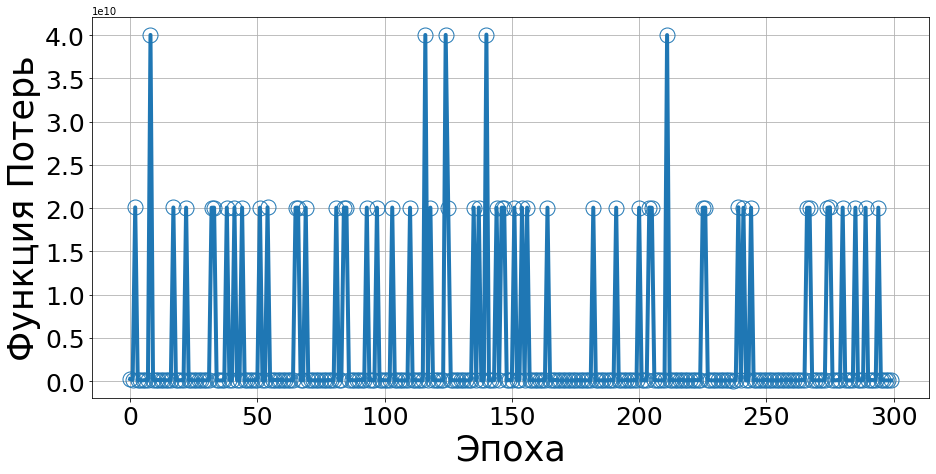

In [33]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

print(r2_score(weights, X_test, y_test))

Объеденим все функции в один класс

In [34]:
class LinearRegression():
    def __init__(self, 
                 learning_rate = 0.5, 
                 epochs = 100, 
                 weights = None, 
                 bias    = None, 
                 batch_size   = 1000, 
                 random_state = 42):
        self.lr      = learning_rate
        self.epochs  = epochs
        self.weights = weights
        self.bias    = bias
        self.seed    = random_state
        self.batch_size = batch_size
        self.cost    = np.zeros(epochs)
        
        # если веса и смещения заданы
        if not(self.weights is None) and (self.bias):
            if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
                self.weights = np.append(self.bias,self.weights)
    
    #---------------------------------
    def forward(self, X):
        return self.weights.dot(X.T)
    
    #---------------------------------
    def loss(self,yhat, y):
        return np.square(yhat - y).sum()/y.size
    
    #---------------------------------
    def grad_step(self,yhat, y, X):
        return 2*np.dot(X.T, (yhat - y)) / y.size
    
    #---------------------------------
    def update(self):    
        return self.weights - self.lr*self.grad
    
    #---------------------------------
    def init(self, weights_size):
        np.random.seed(self.seed)
        return np.random.randn(weights_size)/np.sqrt(weights_size)
    
    #---------------------------------
    def add_bias(self, X):
        return np.column_stack((np.ones(X.shape[0]), X))

    #---------------------------------
    def predict(self, X):
        yhat = self.forward(self.add_bias(X))
        return yhat
    
    #---------------------------------
    def score(self, X, y):        
        yhat = self.predict(X)
        return 1-np.sum(np.square(y-yhat))/np.sum(np.square(y-np.mean(y)))

     #---------------------------------
    def load_batch(self,X,y):
        idx_batch = np.random.randint(0,X.shape[0],self.batch_size)
        x_batch   = np.take(X, idx_batch, axis=0)
        x_batch   = self.add_bias(x_batch)
        y_batch   = np.take(y, idx_batch)
        return  x_batch, y_batch

    #---------------------------------
    def fit(self, X, y):

        np.random.seed(self.seed)
        
        if self.weights is None:
            self.weights = self.init(X.shape[1])
        
        if self.bias is None: 
            self.bias    = self.init(1)
        
        if self.weights.size == X.shape[1]:
            #совмещаем в один массив, если мы этого не сделали
            self.weights = np.append(self.bias,self.weights)
        
        self.grad    = np.zeros(self.weights.shape)
        self.cost    = np.zeros(self.epochs)

        if self.batch_size is None:            
            x_batch   = self.add_bias(X)
            y_batch   = y
        
        for i in range(self.epochs): 

            if self.batch_size: 
                x_batch, y_batch = self.load_batch(X,y)

            yhat         = self.forward(x_batch)
            self.grad    = self.grad_step(yhat,  y_batch, x_batch) 
            self.weights = self.update()  
            self.cost[i] = self.loss(yhat,  y_batch)

        self.bias = self.weights[0]
     
    #---------------------------------
    def plot_cost(self, figsize = (12,6), title = ''):
        plt.figure(figsize = figsize)
        plt.plot(self.cost)
        plt.grid()
        plt.xlabel('Эпоха', fontsize = 24)
        plt.ylabel('Функция Потерь', fontsize = 24)
        plt.title(title, fontsize = 24)
        plt.show()
    
    #---------------------------------
    def get_w_and_b(self):
        return (self.weights[1:], self.bias)

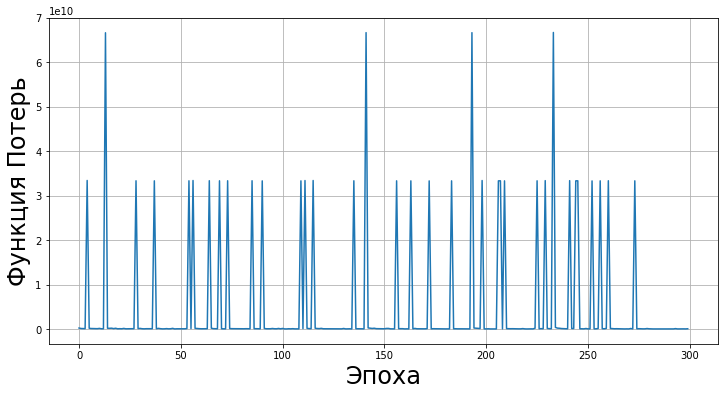

train R2: 0.0077; test R2: 0.2809


In [35]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))


посмотрим веса

In [36]:
def vis_weigths(weights, names):
    numbers = np.arange(0,len(weights))
    tick_labels = names
    cc=['']*len(numbers)
    for n,val in enumerate(weights):
        if val<0:
            cc[n]='red'
        elif val>=0:
            cc[n]='blue'

    plt.bar(x = numbers, height = weights, color = cc)
    plt.xticks(np.arange(0,len(weights)),tick_labels, rotation = 45 );

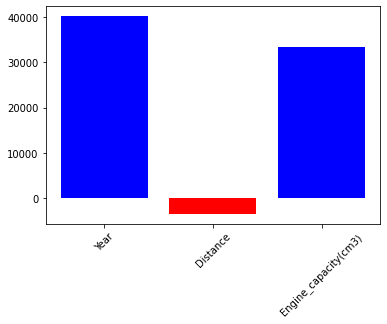

In [37]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)


In [38]:
np.sum(np.abs(w))

77157.67347354614

#Стандартизация

## Загрузка данных на Google Drive

In [40]:
uploaded = files.upload()

Saving cars_moldova_standartization.csv to cars_moldova_standartization.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [41]:
df = pd.read_csv('/content/cars_moldova_standartization.csv', delimiter = ',')
df

,Make,Model,Year,Style,Distance,Engine_capacity(cm3),Fuel_type,Transmission,Price(euro)
0,Toyota,Prius,2011,Hatchback,195000.0,1800.0,Hybrid,Automatic,7750.0
1,Renault,Grand Scenic,2014,Universal,135000.0,1500.0,Diesel,Manual,8550.0
2,Renault,Laguna,2012,Universal,110000.0,1500.0,Diesel,Manual,6550.0
3,Opel,Astra,2006,Universal,200000.0,1600.0,Metan/Propan,Manual,4100.0
4,Mercedes,Vito,2000,Microvan,300000.0,2200.0,Diesel,Manual,3490.0
...,...,...,...,...,...,...,...,...,...
32529,Volkswagen,Passat,2016,Sedan,88000.0,1800.0,Petrol,Automatic,11500.0
32530,Land Rover,Freelander,2002,Crossover,225000.0,1800.0,Metan/Propan,Manual,4400.0
32531,Dacia,Logan Mcv,2015,Universal,89000.0,1500.0,Diesel,Manual,7000.0
32532,Mazda,6,2006,Combi,370000.0,2000.0,Diesel,Manual,4000.0


In [42]:
cat_columns = ['Make', 'Model', 'Style', 'Fuel_type', 'Transmission']
num_columns = ['Year', 'Distance', 'Engine_capacity(cm3)', 'Price(euro)']

## Линейная регрессия 

In [43]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values # x = все параметры кроме Price, y = Price

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32534 entries, 0 to 32533
Data columns (total 4 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Year                  32534 non-null  int64  
 1   Distance              32534 non-null  float64
 2   Engine_capacity(cm3)  32534 non-null  float64
 3   Price(euro)           32534 non-null  float64
dtypes: float64(3), int64(1)
memory usage: 1016.8 KB


,0,1,2
22768,0.76,0.122999,0.375000
22769,0.44,0.299999,0.375000
22770,0.68,0.157084,0.458333
22771,0.84,0.016309,0.208333
22772,0.76,0.240793,0.250000


In [44]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[-0.1382643   1.17674787  1.00749302]
0.42014694097246924 7750.0 7749.579853059027


Проведем расчет градиента ошибки

In [45]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-0.89050935 -0.85150394 -0.53950036]
[-1.03915785e+07 -1.00763690e+09 -9.30126372e+06]


Теперь проведем обновление весовых параметров

In [46]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[  103914.89475916 10076368.18248886    93012.09773649]


In [47]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.28677805, -0.07982693,  0.37394315])

Протестируем обучение

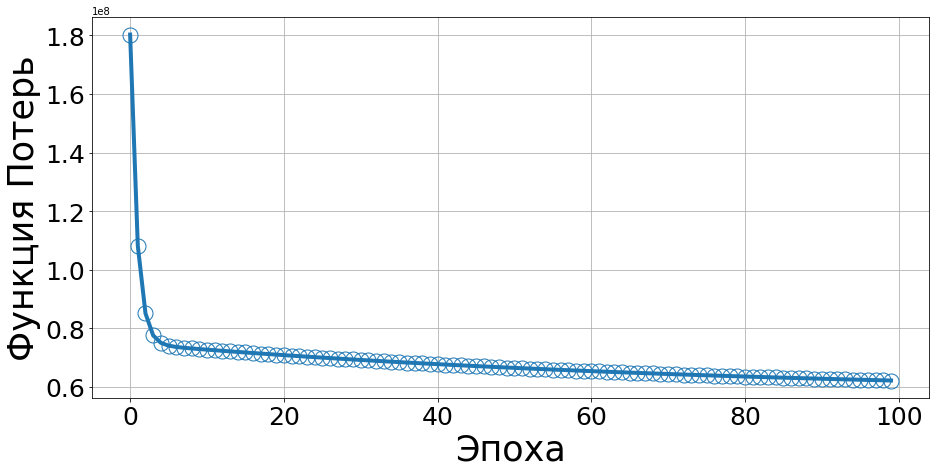

In [48]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost);

посмотрим как выглядят наши ответы на фоне реальных

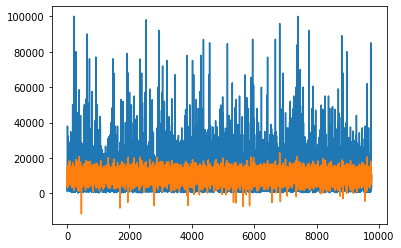

In [49]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted');

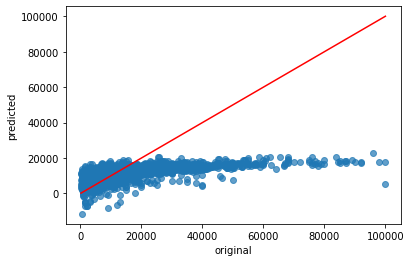

In [50]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted');

MSE

In [51]:
mean_square_error(weights, X_test, y_test)

592541687499.992

MAE

In [52]:
mean_absolute_error(weights, X_test, y_test)

48416052.361327

Коэффициент детерменации

In [53]:
r2_score(weights, X_test, y_test)

0.31909482688393864

0.3625361296257428


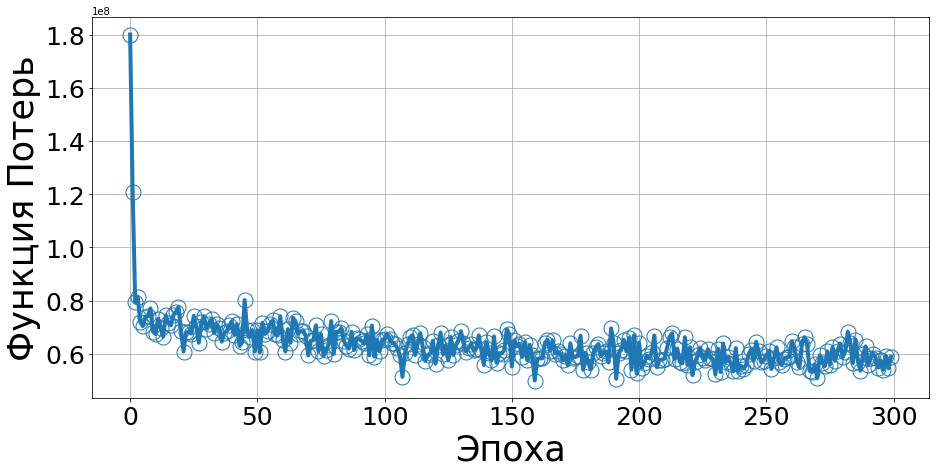

In [54]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

print(r2_score(weights, X_test, y_test))

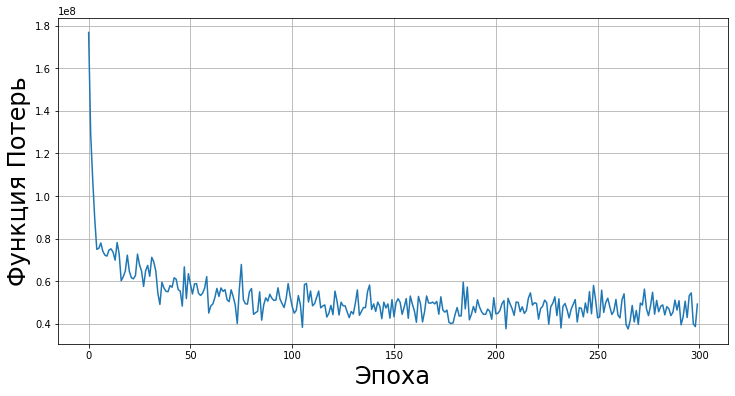

train R2: 0.4794; test R2: 0.4738


In [55]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))


посмотрим веса

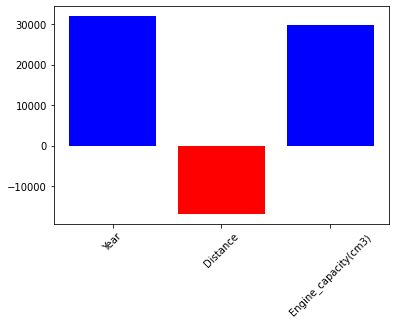

In [56]:
w, b = regr.get_w_and_b()

vis_weigths(w, features_names)


In [57]:
np.sum(np.abs(w))

78688.46749337456

#One-hot кодирование

## Загрузка данных на Google Drive

In [58]:
uploaded = files.upload()

Saving cars_moldova_onehot.csv to cars_moldova_onehot.csv


## Считываем файл в DataFrame



метод .read_csv(path,delimiter) 

In [59]:
df = pd.read_csv('/content/cars_moldova_onehot.csv', delimiter = ',')
df

,Year,Distance,Engine_capacity(cm3),Transmission,Price(euro),Age,km_year,Make_Alfa Romeo,Make_Audi,Make_BMW,...,Style_Roadster,Style_SUV,Style_Sedan,Style_Universal,Fuel_type_Diesel,Fuel_type_Electric,Fuel_type_Hybrid,Fuel_type_Metan/Propan,Fuel_type_Petrol,Fuel_type_Plug-in Hybrid
0,2011,195000.0,1800.0,1,7750.0,11,17727.272727,0,0,0,...,0,0,0,0,0,0,1,0,0,0
1,2014,135000.0,1500.0,0,8550.0,8,16875.000000,0,0,0,...,0,0,0,1,1,0,0,0,0,0
2,2012,110000.0,1500.0,0,6550.0,10,11000.000000,0,0,0,...,0,0,0,1,1,0,0,0,0,0
3,2006,200000.0,1600.0,0,4100.0,16,12500.000000,0,0,0,...,0,0,0,1,0,0,0,1,0,0
4,2000,300000.0,2200.0,0,3490.0,22,13636.363636,0,0,0,...,0,0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32215,2016,88000.0,1800.0,1,11500.0,6,14666.666667,0,0,0,...,0,0,1,0,0,0,0,0,1,0
32216,2002,225000.0,1800.0,0,4400.0,20,11250.000000,0,0,0,...,0,0,0,0,0,0,0,1,0,0
32217,2015,89000.0,1500.0,0,7000.0,7,12714.285714,0,0,0,...,0,0,0,1,1,0,0,0,0,0
32218,2006,370000.0,2000.0,0,4000.0,16,23125.000000,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [80]:
cat_columns = []
num_columns = []

for column_name in df.columns:
    if (df[column_name].dtypes == object):
        cat_columns +=[column_name]
    else:
        num_columns +=[column_name]

print('Категориальные данные:\t ',cat_columns, '\n Число столблцов = ',len(cat_columns))

print('Числовые данные:\t ',  num_columns, '\n Число столблцов = ',len(num_columns))

Категориальные данные:	  [] 
 Число столблцов =  0
Числовые данные:	  ['Year', 'Distance', 'Engine_capacity(cm3)', 'Transmission', 'Price(euro)', 'Age', 'km_year', 'Make_Alfa Romeo', 'Make_Audi', 'Make_BMW', 'Make_Chevrolet', 'Make_Chrysler', 'Make_Citroen', 'Make_Dacia', 'Make_Daewoo', 'Make_Daihatsu', 'Make_Dodge', 'Make_Fiat', 'Make_Ford', 'Make_GAZ', 'Make_Honda', 'Make_Hyundai', 'Make_Infiniti', 'Make_Jaguar', 'Make_Jeep', 'Make_KIA', 'Make_Land Rover', 'Make_Lexus', 'Make_Lincoln', 'Make_Mazda', 'Make_Mercedes', 'Make_Mini', 'Make_Mitsubishi', 'Make_Moskvich / Izh', 'Make_Nissan', 'Make_Opel', 'Make_Peugeot', 'Make_Porsche', 'Make_Rare', 'Make_Renault', 'Make_Rover', 'Make_Seat', 'Make_Skoda', 'Make_Smart', 'Make_Ssangyong', 'Make_Subaru', 'Make_Suzuki', 'Make_Toyota', 'Make_Vaz', 'Make_Volkswagen', 'Make_Volvo', 'Model_100', 'Model_206', 'Model_2106', 'Model_2107', 'Model_2121niva', 'Model_3', 'Model_3 Series', 'Model_307', 'Model_323', 'Model_5 Series', 'Model_6', 'Model_626', 

## Линейная регрессия своими руками

In [81]:
df_num = df[num_columns].copy()

df_num.info()

X,y = df_num.drop(columns = ['Price(euro)']).values,df_num['Price(euro)'].values # x = все параметры кроме Price, y = Price

features_names = df_num.drop(columns = ['Price(euro)']).columns

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

scaler  = MinMaxScaler()
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train) 
X_test  = scaler.transform(X_test) 

pd.DataFrame(X_train).tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32220 entries, 0 to 32219
Columns: 205 entries, Year to Fuel_type_Plug-in Hybrid
dtypes: float64(4), int64(201)
memory usage: 50.4 MB


,0,1,2,3,4,5,6,7,8,9,...,194,195,196,197,198,199,200,201,202,203
22549,0.40,0.011012,0.291667,0.0,0.60,0.005179,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22550,0.74,0.208921,0.270833,1.0,0.26,0.297166,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
22551,0.84,0.155127,0.270833,0.0,0.16,0.343601,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
22552,0.84,0.219922,0.229167,1.0,0.16,0.487865,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
22553,0.94,0.049905,0.375000,1.0,0.06,0.248497,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


Протестируем обе функции

In [82]:
weights = np.random.randn(X.shape[1])
print(weights)
yhat = forward(weights, X_train[0])
loss = np.sqrt(loss_func(yhat, y[0]))
print(yhat, y[0], loss)

[-1.38264301e-01 -1.27468225e+00  1.91386148e-01 -1.30424901e+00
 -1.10484632e-02  2.27537615e-01  1.28330519e+00 -1.30494564e+00
 -1.01070334e-01 -6.06098592e-01 -8.22839104e-01  9.04450092e-01
 -4.09329097e-01  1.94609237e+00 -5.18891523e-01 -5.93116988e-01
 -1.20061718e+00 -1.01960088e-01  8.51115449e-01  4.52204451e-02
 -6.13062108e-01 -2.60232026e-01  9.89724209e-01  8.86863895e-01
  2.47609576e+00  1.80993312e+00 -5.81590640e-01 -1.14114045e+00
 -3.29963867e-01  8.37693120e-01 -2.18082486e-01 -6.95555264e-01
 -1.44080619e+00 -1.00031285e+00 -1.53846787e-01  8.09716764e-01
  1.70664466e+00  1.30428386e+00  9.48571419e-01  1.71086936e+00
  1.23469387e+00  2.41533119e-01  3.94329664e-01 -1.26333200e+00
  3.71646102e-01  4.98418301e-01 -9.91536538e-01 -9.71882834e-01
  9.56805670e-01 -6.61525087e-01 -2.78625165e-01  7.95352123e-01
 -9.19202109e-01  3.76326841e-01 -1.47316206e+00 -5.00968862e-01
 -4.23110603e-02 -1.64829295e+00 -1.38517395e-01 -1.99481435e+00
 -5.37233981e-01 -5.31003

Проведем расчет градиента ошибки

In [83]:
weights = np.random.randn(X.shape[1])
yhat = forward(weights, X_train[0])
print(weights)
grad = grad_loss(yhat, y[0], X[0])
print(grad)

[-0.69365096  1.6157648  -0.09112757 -0.1684008  -0.3305541   0.61282039
  0.9719294   0.70199053 -0.48754646  1.48847294  1.16509304  0.07641223
  0.85201036  0.87917451  1.62979757 -2.44985516  1.30282739 -1.30632017
 -0.97454282  0.02227571 -0.54294665  0.0574064   0.82849766 -0.87509852
 -0.65312073  1.1510061   1.07168782  0.39356705 -0.425979   -1.16750317
  0.02591675 -0.55171234  2.02988684 -1.65501881  1.06274235 -1.12532863
 -0.60090145  0.22664811 -0.63778072  0.85911053 -0.67660131 -2.4532744
 -0.33017526  0.45788918  1.57522803  0.13013465 -0.03396512 -0.8193401
  1.24045693  0.44729609  1.28527533 -1.13170949  0.87622909 -0.39511242
 -1.45347752  0.86419496 -0.88221676 -0.42390717  0.7192256  -0.51671334
  0.47002371 -0.46168645  0.25009386 -2.6896036  -2.28152102  0.3761708
 -0.48929693  0.59214212 -0.65625842 -0.31446733 -1.42701635  0.55605701
  0.07085216 -0.32516151 -2.35814836 -0.3144989   0.46416779 -1.9315906
 -1.23008175 -1.87829078 -0.55313848  0.51618418 -1.357

теперь проведем обновление весовых параметров

In [84]:
lerning_rate = 0.01
weights = update_weights(grad, weights, lerning_rate)
print(weights)

[ 1.52660806e+03  1.48098997e+05  1.36696162e+03  5.91072953e-01
  8.02365714e+00  1.34640111e+04  9.71929399e-01  7.01990527e-01
 -4.87546465e-01  1.48847294e+00  1.16509304e+00  7.64122310e-02
  8.52010359e-01  8.79174507e-01  1.62979757e+00 -2.44985516e+00
  1.30282739e+00 -1.30632017e+00 -9.74542823e-01  2.22757123e-02
 -5.42946651e-01  5.74063965e-02  8.28497662e-01 -8.75098517e-01
 -6.53120732e-01  1.15100610e+00  1.07168782e+00  3.93567047e-01
 -4.25978999e-01 -1.16750317e+00  2.59167508e-02 -5.51712343e-01
  2.02988684e+00 -1.65501881e+00  1.06274235e+00 -1.12532863e+00
 -6.00901450e-01  2.26648110e-01 -6.37780716e-01  8.59110532e-01
 -6.76601311e-01 -2.45327440e+00 -3.30175265e-01  4.57889179e-01
  1.57522803e+00  1.30134650e-01  7.25508631e-01 -8.19340098e-01
  1.24045693e+00  4.47296087e-01  1.28527533e+00 -1.13170949e+00
  8.76229089e-01 -3.95112416e-01 -1.45347752e+00  8.64194957e-01
 -8.82216761e-01 -4.23907170e-01  7.19225600e-01 -5.16713343e-01
  4.70023710e-01 -4.61686

In [85]:
weights = weights_init(X_train.shape[1], random_state=42)
weights

array([ 0.03477695, -0.00968044,  0.04534727,  0.10663342, -0.01639402,
       -0.01639287,  0.11056701,  0.05373118, -0.03286978,  0.0379868 ,
       -0.03244573, -0.0326076 ,  0.01694075, -0.13395641, -0.1207684 ,
       -0.039368  , -0.07091236,  0.02200171, -0.0635744 , -0.09888104,
        0.10261594, -0.0158075 ,  0.00472792, -0.09975233, -0.03811441,
        0.00776613, -0.08058567,  0.02630412, -0.04205312, -0.02042265,
       -0.04212789,  0.12968541, -0.00094499, -0.07405458,  0.05758966,
       -0.08547615,  0.01462338, -0.13720435, -0.09299162,  0.01378304,
        0.051703  ,  0.01199818, -0.008097  , -0.02108148, -0.10351724,
       -0.05039918, -0.03225116,  0.07401336,  0.02405809, -0.1234375 ,
        0.02269042, -0.02696115, -0.04739402,  0.04282591,  0.0721844 ,
        0.06520265, -0.05875698, -0.0216492 ,  0.02319308,  0.06830182,
       -0.03354891, -0.01299873, -0.07745894, -0.08375122,  0.05688819,
        0.0949558 , -0.00504172,  0.07026136,  0.02531959, -0.04

Протестируем обучение

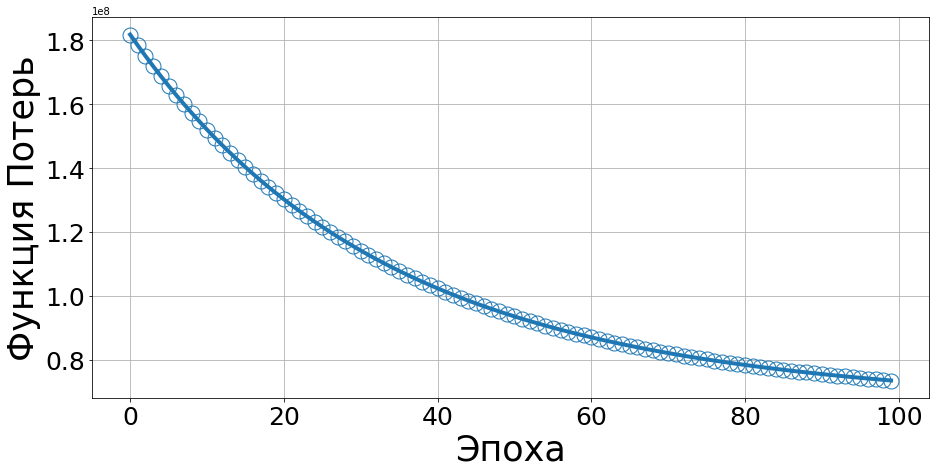

In [86]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit(X_train, y_train, weights, lr=0.9,  epochs=100)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost);

посмотрим как выглядят наши ответы на фоне реальных

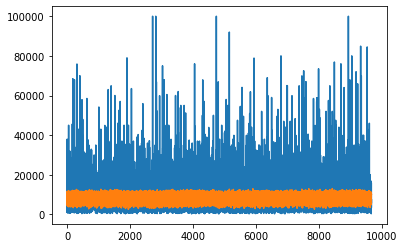

In [87]:
yhat = predict(weights, X_test)
plt.plot(y_test, label='original')
plt.plot(yhat, label='predicted');

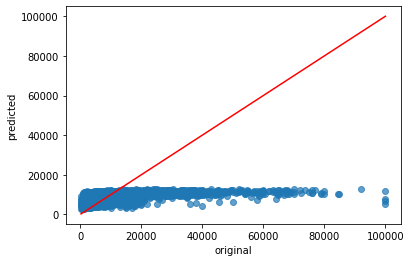

In [88]:
plt.scatter(y_test,yhat,alpha = 0.7)
plt.plot([y_test.min(),y_test.max()],[y_test.min(),y_test.max()], 'r')
plt.xlabel('original')
plt.ylabel('predicted');

MSE

In [89]:
mean_square_error(weights, X_test, y_test)

663098809751.9878

MAE

In [90]:
mean_absolute_error(weights, X_test, y_test)

44874917.66640562

Коэффициент детерменации

In [91]:
r2_score(weights, X_test, y_test)

0.21155395918929587

0.32257106315237305


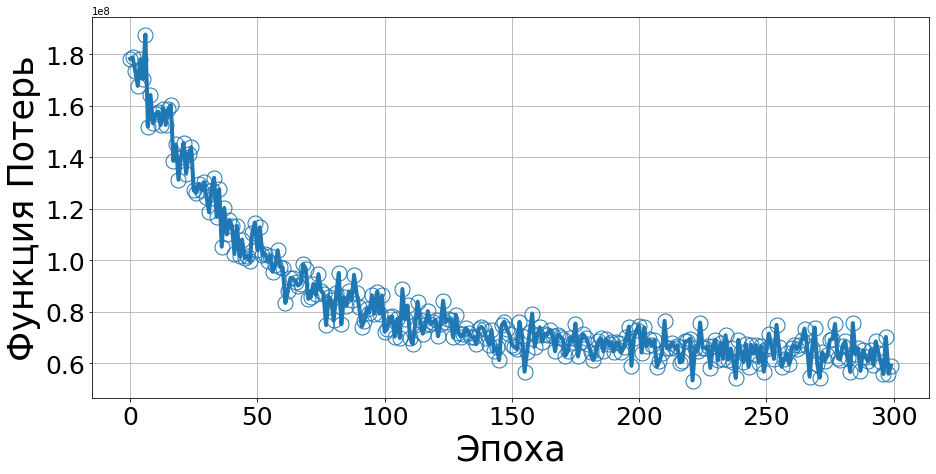

In [92]:
weights = weights_init(X_train.shape[1], random_state=42)

weights, cost = fit_SGD(X_train, y_train, weights, lr=0.7,  epochs=300)

fig  = plt.figure(figsize=(15,7))
plot_cost(cost)

print(r2_score(weights, X_test, y_test))

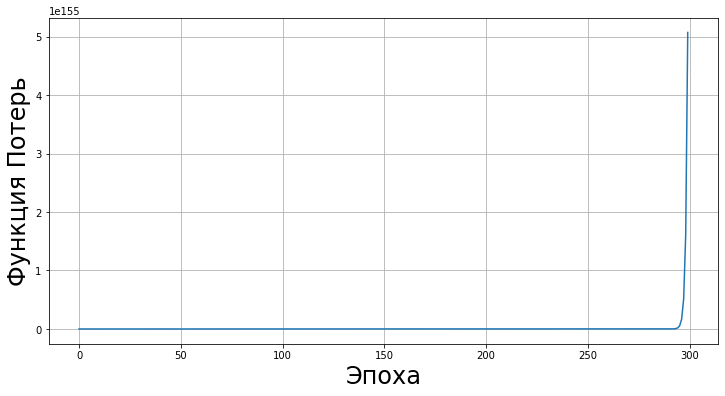

train R2: -17127757634889385603750981938097603347970200378687137606593839042437374059677130409146203089102539194325519827477425710538762150856087717317762351104.0000; test R2: -18180248078394477724125293981629533697654310917725749349669797166166329826929243709027301895813463040109134371758112935245638905937388701134293565440.0000


In [93]:
regr = LinearRegression(learning_rate=0.5,epochs=300,batch_size=3000)
regr.fit(X_train, y_train)

regr.plot_cost()

print( 'train R2: %.4f; test R2: %.4f' % (regr.score(X_train, y_train), regr.score(X_test, y_test)))


посмотрим веса

In [101]:
w, b = regr.get_w_and_b()
plt.figure(figsize=(199,100))
vis_weigths(w, features_names)


In [95]:
np.sum(np.abs(w))

2.87150729294782e+78